# **Visual Transformer 2D**


In [1]:
import os
import sys
import re
from glob import glob
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn.functional import kl_div
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

import open3d as o3
import math
import yaml
import argparse


np.random.seed(0)
torch.manual_seed(0)

#from open3d.web_visualizer import draw # for non Colab
#sys.path.append('../../PointNet-VAE/src')
sys.path.append('../src')


from tqdm import tqdm, trange

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# TEMP for supressing pytorch user warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
print('MPS is build: {}'.format(torch.backends.mps.is_built()))
print('MPS Availability: {}'.format(torch.backends.mps.is_available()))
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps'
print('Device is set to :{}'.format(DEVICE))
torch.seed = 42

MPS is build: True
MPS Availability: True
Device is set to :mps


# DATA LOADING

In [4]:
transform = ToTensor()

train_set = MNIST(
    root="./../data", train=True, download=True, transform=transform
)
test_set = MNIST(
    root="./../data", train=False, download=True, transform=transform
)
train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

## PRE & POST PROCESSING SCRIPTS

In [188]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches**2, h * w * c // n_patches**2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[
                    :,
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

def depatchify(patches, n_patches, chw):
    # size of patches is expected to be n, h, w
    patch_h = chw[1] // n_patches
    patch_w = chw[2] // n_patches
    n = patches.shape[0]

    images_recovered = torch.zeros(n, chw[0], chw[1], chw[2])

    for idx, patch in enumerate(patches):
        
        image_r = torch.empty(0, w)
        
        for i in range(n_patches):
            #patch_r_i_1 = patch[i, :].view(patch_h, patch_w)
            row_tensor = torch.empty(patch_h, 0)
            for j in range(n_patches):
                patch_r_row = patch[i*n_patches+j, :].view(patch_h, patch_w)
                row_tensor = torch.cat((row_tensor, patch_r_row), dim=1)
            
            image_r = torch.cat((image_r, row_tensor), dim=0)

        images_recovered[idx] = image_r
    return images_recovered

def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result

def TensorToImageGrid(images_batch, rows, cols):
    grid = torchvision.utils.make_grid(images_batch, nrow=cols)
    grid = grid.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(cols, rows))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    return plt.show()

def TensorToImage(image):
    plt.imshow(image.numpy(), cmap='gray')
    return plt.show()

In [6]:
class SelfAttentionLayer(nn.Module):
    '''
    hidden_d: number of hidden dimensions
    n_heads: number of attention heads
    
    '''
    def __init__(self, hidden_d, n_heads=2):
        super(SelfAttentionLayer, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        assert hidden_d % n_heads == 0, f"{hidden_d} cannot be divided into {n_heads} heads!"

        d_head = int(hidden_d / n_heads) ## Hidded dimensions per head
        
        # Define the linear transformation layers for Query, Key, and Value
        self.q_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.k_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.v_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)

        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head**0.5)) # Apply the softmax function to calculated the scaled dot-product attention scores to get attention weights
                # attention = F.dropout(attention, p=0.1) # Drop out to attention - optional
                seq_result.append(attention @ v)  # Calculate the weighted sum using the attention weights
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])



In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_d, n_heads):
        super(MultiHeadAttention, self).__init__()
        assert hidden_d % n_heads == 0, f"{hidden_d} cannot be divided into {n_heads} heads!"

        self.hidden_d = hidden_d
        self.n_heads = n_heads
        self.d_k = hidden_d // n_heads ## Hidded dimensions per head
        
        # Define the linear transformation layers for Query, Key, and Value
        self.W_q = nn.Linear(hidden_d, hidden_d)
        self.W_k = nn.Linear(hidden_d, hidden_d)
        self.W_v = nn.Linear(hidden_d, hidden_d)
        self.W_o = nn.Linear(hidden_d, hidden_d)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Apply the softmax function to calculated the scaled dot-product attention scores to get attention weights
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V) # Calculate the weighted sum using the attention weights
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, hidden_d = x.size()
        return x.view(batch_size, seq_length, self.n_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.hidden_d)
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

![Alt text](image.png)

In [8]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, hidden_d, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(hidden_d, d_ff)
        self.fc2 = nn.Linear(d_ff, hidden_d)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [9]:

class VisualTransformerEncoderBlock(nn.Module):
    '''
    Not typical transformer block, the normalization and linear layers are there but the order is different.
    '''
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(VisualTransformerEncoderBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MultiHeadAttention(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x), self.norm1(x), self.norm1(x)) 
        out = out + self.mlp(self.norm2(out))
        return out


In [10]:
class VisualTransformerEncoder(nn.Module):
    def __init__(self, chw, n_patches=7, num_layers=2, hidden_d=8, n_heads=2):
        # Super constructor
        super(VisualTransformerEncoder, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.num_layers = num_layers
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2, hidden_d),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList(
            [VisualTransformerEncoderBlock(hidden_d, n_heads) for _ in range(num_layers)]
        )

    def forward(self, images):
        # Image to Patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Patch vector to Hidden Dimensions
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        #tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        return out

In [11]:
#class VisualTransformer(nn.Module):
#    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
#        # Super constructor
#        super(VisualTransformer, self).__init__()
#
#        # Attributes
#        self.chw = chw  # ( C , H , W )
#        self.n_patches = n_patches
#        self.n_blocks = n_blocks
#        self.n_heads = n_heads
#        self.hidden_d = hidden_d
#
#        # Input and patches sizes
#        assert (
#            chw[1] % n_patches == 0
#        ), "Input shape not entirely divisible by number of patches"
#        assert (
#            chw[2] % n_patches == 0
#        ), "Input shape not entirely divisible by number of patches"
#        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)
#
#        # 1) Linear mapper
#        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
#        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
#
#        # 2) Learnable classification token
#        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
#
#        # 3) Positional embedding
#        self.register_buffer(
#            "positional_embeddings",
#            get_positional_embeddings(n_patches**2 + 1, hidden_d),
#            persistent=False,
#        )
#
#        # 4) Transformer encoder blocks
#        self.blocks = nn.ModuleList(
#            [VisualTransformerBlock(hidden_d, n_heads) for _ in range(n_blocks)]
#        )
#
#        # 5) Classification MLPk
#        self.mlp = nn.Sequential(nn.Linear(self.hidden_d, out_d), nn.Softmax(dim=-1))
#
#    def forward(self, images):
#        # Image to Patches
#        n, c, h, w = images.shape
#        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
#
#        # Patch vector to Hidden Dimensions
#        tokens = self.linear_mapper(patches)
#
#        # Adding classification token to the tokens
#        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
#
#        # Adding positional embedding
#        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
#
#        # Transformer Blocks
#        for block in self.blocks:
#            out = block(out)
#
#        # Getting the classification token only
#        out = out[:, 0]
#
#        return self.mlp(out)  # Map to output dimension, output category distribution
#


![Alt text](image-1.png)

In [12]:
class VisualTransformerDecoderBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, d_ff, dropout):
        super(VisualTransformerDecoderBlock, self).__init__()
        self.self_attn = MultiHeadAttention(hidden_d, n_heads)
        self.cross_attn = MultiHeadAttention(hidden_d, n_heads)
        self.feed_forward = PositionWiseFeedForward(hidden_d, d_ff)
        self.norm1 = nn.LayerNorm(hidden_d)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.norm3 = nn.LayerNorm(hidden_d)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [35]:
class VisualTransformerDecoder(nn.Module):
    def __init__(self, chw, d_ff, dropout, n_patches=7, num_layers=2, hidden_d=8, n_heads=2):
        # Super constructor
        super(VisualTransformerDecoder, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.num_layers = num_layers
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        self.d_ff = d_ff
        self.dropout = dropout
        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2, hidden_d),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList(
            [VisualTransformerDecoderBlock(hidden_d, n_heads, d_ff, dropout) for _ in range(num_layers)]
        )

        self.linear_decoder = nn.Linear(self.hidden_d, self.input_d)

    def forward(self, images,  enc_output, src_mask, tgt_mask):
        # Image to Patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Patch vector to Hidden Dimensions
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        #tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out, enc_output, src_mask, tgt_mask)
        
        return self.linear_decoder(out)

In [36]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, hidden_d, n_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, hidden_d)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, hidden_d)
        self.positional_encoding = PositionalEncoding(hidden_d, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(hidden_d, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(hidden_d, n_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(hidden_d, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [37]:
n_patches = 7
num_layers = 2
hidden_d = 64
n_heads = 8
d_ff = 512
dropout = 0.1


encoder = VisualTransformerEncoder((1, 28, 28), n_patches=n_patches, num_layers=num_layers, hidden_d=hidden_d, n_heads=n_heads).to(DEVICE)
#decoder_layers = nn.ModuleList([VisualTransformerDecoderBlock(hidden_d, n_heads, d_ff, dropout) for _ in range(num_layers)])
decoder = VisualTransformerDecoder((1, 28, 28), d_ff=d_ff, dropout=dropout, n_patches=n_patches, num_layers=num_layers, hidden_d=hidden_d, n_heads=n_heads).to(DEVICE)

In [130]:
images, classes = next(iter(train_loader))
print(images.shape, classes.shape)
patches = patchify(images, n_patches).unsqueeze(1)
print(patches.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 49, 16])


In [39]:
def generate_mask(patches):
    src = torch.ones((patches.size(0), patches.size(2)))
    tgt = torch.ones((patches.size(0), patches.size(2)))

    src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
    tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
    seq_length = tgt.size(1)
    nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
    tgt_mask = tgt_mask & nopeak_mask
    return src_mask, tgt_mask

In [40]:
src_mask, tgt_mask = generate_mask(patches)
src_mask = src_mask.to(DEVICE)
tgt_mask = tgt_mask.to(DEVICE)
#src_embedded = positional_encoding(encoder_embedding(src))
#tgt_embedded = positional_encoding(decoder_embedding(tgt))
#enc_output = src_embedded
enc_output = encoder(images)
print('Encoded Latent Shape: {}'.format(enc_output.shape))
dec_output = decoder(images, enc_output, src_mask, tgt_mask)
print('Decoded Sequence Shape: {}'.format(dec_output.shape))

Encoded Latent Shape: torch.Size([128, 49, 64])
Decoded Sequence Shape: torch.Size([128, 49, 16])


In [ ]:
dec_output = tgt_embedded
for dec_layer in decoder_layers:
    dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)
#output = self.fc(dec_output)
dec_output

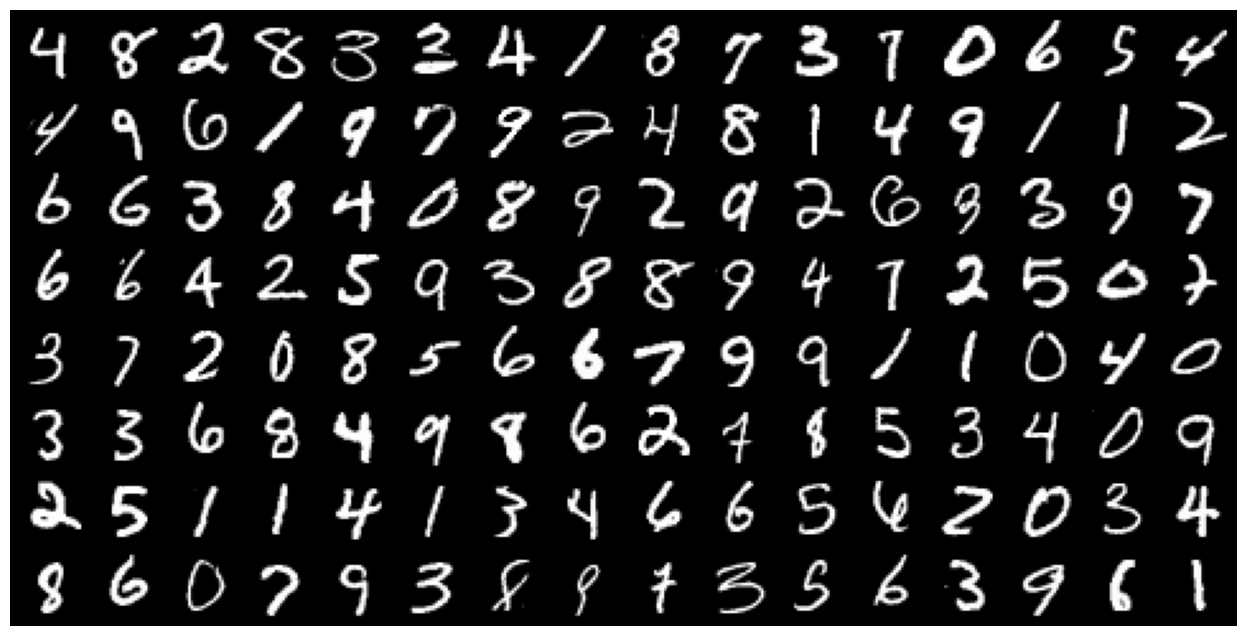

In [187]:
#TensorToImage(depatchify(dec_output.detach().cpu(), n_patches, chw)[0].squeeze())
#TensorToImageGrid(depatchify(dec_output.detach().cpu(), n_patches, chw), rows=16, cols=8)
TensorToImageGrid(depatchify(patches.squeeze(1), n_patches, chw), rows=8, cols=16)


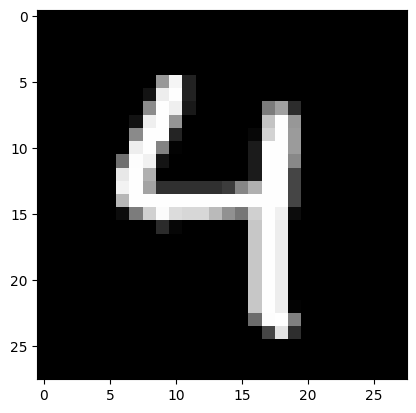

In [165]:
TensorToImage(image_r)

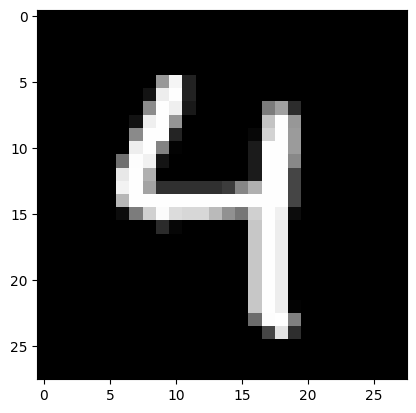

In [164]:
TensorToImage(images[0].squeeze())

In [ ]:

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = VisualTransformer(
        (1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10
    ).to(device)
    N_EPOCHS = 5
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(
            train_loader, desc=f"Epoch {epoch + 1} in training", leave=False
        ):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")


if __name__ == "__main__":
    main()

In [ ]:
encoder = PointCloudEncoder(latent_dim=LATENT_DIM, num_point=NUM_POINTS).to(DEVICE)
#encoder = PointNetBackbone(num_points=NUM_POINTS, num_global_feats=LATENT_DIM, local_feat=False).to(DEVICE)
decoder = PointCloudDecoderMLP(latent_dim=LATENT_DIM, num_hidden=3, num_point=NUM_POINTS).to(DEVICE)
autoencoder = AutoEncoder(encoder, decoder, device=DEVICE, latent_dim=LATENT_DIM).to(DEVICE)
vae = VAE(encoder, decoder, device=DEVICE, latent_dim=LATENT_DIM).to(DEVICE)

In [ ]:
from utils.train import Trainer

model_run = Trainer(model=vae, 
                    criterion=ChamferDistanceLoss(),
                    optimizer=optim.Adam(vae.parameters(), config['trainer_parameters']['lr']),
                    **config['model_parameters']
                    )

In [ ]:
points, _, _ = model_run._sanitizer(next(iter(train_loader)))
PointsTo3DShape(points[0][0].squeeze())


In [ ]:
points = points.to(config['model_parameters']['device'])
global_features, _, _ = model_run.model.encoder(points)
mu = model_run.model.fc_mu(global_features)
logvar = model_run.model.fc_logvar(global_features)
mu = torch.randn((10000, 128))
logvar = torch.randn((10000, 128))

#mu = torch.zeros_like(mu)
#logvar = torch.zeros_like(logvar)
print(mu.mean())
print(logvar.mean())

model_run.model.reparameterize(mu, logvar)


In [ ]:
plt.hist(mu[0].numpy())

In [ ]:
torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
# sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))
# KL(P || Q) = – sum x in X P(x) * log(Q(x) / P(x))


In [ ]:
model_run.fit(train_loader, val_loader, 100)

# END OF TRAINING CYCLE

In [ ]:
model_evaluate = Evaluater(
        model=vae,
        criterion=ChamferDistanceLoss(),
        encoder_type='ConvolutionEncoder',
        model_type='VAE',
        checkpoint='../models/checkpoints/trial/checkpoint_499.pth',
        device='mps',
        )

In [ ]:
points, reconstructed_x = model_evaluate.evaluate_data(next(iter(val_loader)))

In [ ]:
N=30
PointsTo3DShape(points[N].squeeze().cpu())


In [ ]:
PointsTo3DShape(reconstructed_x[N].cpu())


In [ ]:
import pyvista as pv
point_cloud = pv.PolyData(reconstructed_x[N].cpu().numpy())
mesh = point_cloud.reconstruct_surface()
mesh.plot(color='orange')
